In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio

2024-09-22 14:43:57.793092: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 14:43:57.833721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 14:43:57.833751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 14:43:57.834859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 14:43:57.840870: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 14:43:57.841696: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
sample_rate = 16000
desired_length = 48000

In [9]:
def squeeze(audio, labels=None):
    """
    This dataset only contains single channel audio, so use
    the tf.squeeze function to drop the extra axis
    """
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels


def plot_spectrogram(spectrogram, ax):
    height = spectrogram.shape[0]
    width = spectrogram.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, spectrogram)

In [4]:
# Group1
group1_record_non_target_file1 = (
    "../../dataset/testing/non_target/1.000_0002_36wiH3sPukY_40.wav"
)
group1_record_non_target_file2 = (
    "../../dataset/testing/non_target/0.920_0001_703520.wav"
)
group1_record_non_target_file3 = (
    "../../dataset/testing/non_target/0.930_0012_305620.wav"
)

group1_record_target_file1 = "../../dataset/testing/target/0.770_0001_200624_1661_2.wav"
group1_record_target_file2 = "../../dataset/testing/target/0.940_0041_736736.wav"
group1_record_target_file3 = "../../dataset/testing/target/0.960_0052_86290.wav"

# Group2
group2_record_non_target_file1 = (
    "../../dataset/testing/non_target/1.000_0002_-uBbPbRML3U_290.wav"
)
group2_record_non_target_file2 = (
    "../../dataset/testing/non_target/0.940_0030_112804.wav"
)
group2_record_non_target_file3 = (
    "../../dataset/testing/non_target/0.930_0011_121693.wav"
)

group2_record_target_file1 = (
    "../../dataset/testing/target/0.970_0058_R21_2022_02_23_07_59_47.wav"
)
group2_record_target_file2 = "../../dataset/testing/target/0.940_0009_784426.wav"
group2_record_target_file3 = "../../dataset/testing/target/0.930_0024_420362.wav"

2024-09-22 14:44:06.578155: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-22 14:44:06.578651: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-09-22 14:44:06.661111: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
2024-09-22 14:44:06.668838: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


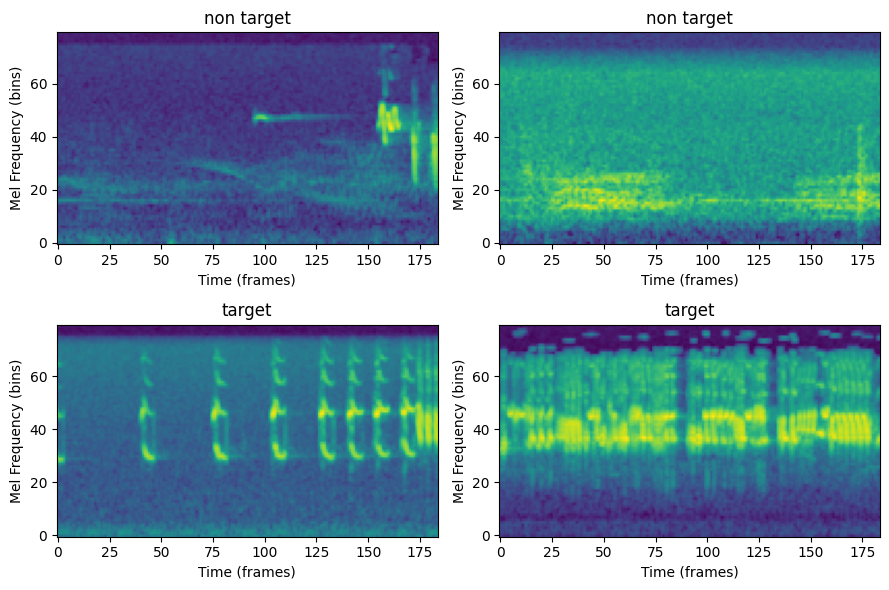

In [5]:
def read_file_and_compute_mel_spectr(file_name):
    audio, sr = tf.audio.decode_wav(tf.io.read_file(file_name))
    audio = tf.squeeze(audio, axis=-1)
    resampled_audio = tfio.audio.resample(audio, rate_in=48000, rate_out=sample_rate)

    # Prepare log mel spectrogram from audio
    audio_length = tf.shape(resampled_audio)[0]
    if audio_length < desired_length:
        audio = tf.pad(audio, [[0, desired_length - audio_length]], mode="CONSTANT")
    else:
        audio = audio[:desired_length]
    # Create log Mel spectrogram
    stfts = tf.signal.stft(audio, frame_length=1024, frame_step=256, fft_length=1024)
    spectrogram = tf.abs(stfts)
    # Warp the linear scale spectrogram into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins,
        num_spectrogram_bins,
        sample_rate,
        lower_edge_hertz,
        upper_edge_hertz,
    )
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(
        spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:])
    )

    mel_spectrogram = mel_spectrogram.numpy()
    return mel_spectrogram


data_points_to_plot = [
    (group1_record_non_target_file2, "non target"),
    (group1_record_non_target_file3, "non target"),
    (group1_record_target_file3, "target"),
    (group2_record_target_file3, "target"),
]

fig, axes = plt.subplots(2, 2, figsize=(9, 6))
axes = axes.flatten()

for i, data_point in enumerate(data_points_to_plot):
    mel_spectr = read_file_and_compute_mel_spectr(data_point[0])
    ax = axes[i]
    ax.imshow(
        np.log(mel_spectr.T + 1e-6), aspect="auto", origin="lower", cmap="viridis"
    )
    ax.set_title(f"{data_point[1]}")
    ax.set_xlabel("Time (frames)")
    ax.set_ylabel("Mel Frequency (bins)")

plt.tight_layout()
plt.show()

In [35]:
fig.savefig(
    "../../figures/target_non_target_species_spectrograms.pdf", bbox_inches="tight"
)

Different types of spectrogram

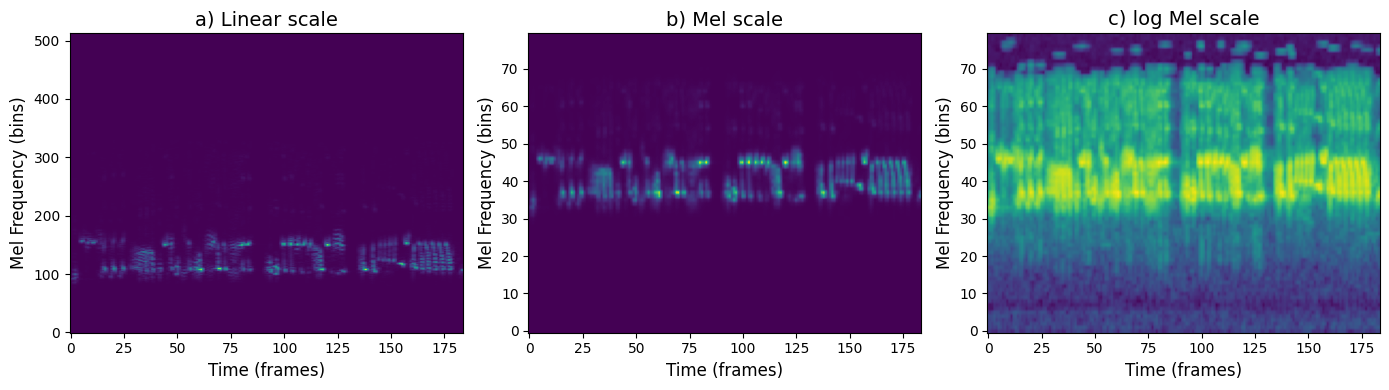

In [7]:
def read_file_and_compute_simple_spectr(file_name):
    audio, sr = tf.audio.decode_wav(tf.io.read_file(file_name))
    audio = tf.squeeze(audio, axis=-1)
    resampled_audio = tfio.audio.resample(audio, rate_in=48000, rate_out=sample_rate)

    # Prepare log mel spectrogram from audio
    audio_length = tf.shape(resampled_audio)[0]
    if audio_length < desired_length:
        audio = tf.pad(audio, [[0, desired_length - audio_length]], mode="CONSTANT")
    else:
        audio = audio[:desired_length]
    # Create log Mel spectrogram
    stfts = tf.signal.stft(audio, frame_length=1024, frame_step=256, fft_length=1024)
    spectrogram = tf.abs(stfts)
    return spectrogram.numpy()


data_points_to_plot = [
    # (group1_record_non_target_file2, "non target"),
    # (group1_record_non_target_file3, "non target"),
    (group1_record_target_file1, "target"),
    # (group2_record_target_file3, "target"),
]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes = axes.flatten()

for i in range(3):
    if i == 0:
        target_spectr = read_file_and_compute_simple_spectr(data_point[0])
        ax = axes[i]
        ax.imshow(target_spectr.T, aspect="auto", origin="lower", cmap="viridis")
        ax.set_title("a) Linear scale", fontsize=14)
    elif i == 1:
        target_spectr = read_file_and_compute_mel_spectr(data_point[0])
        ax = axes[i]
        ax.imshow(target_spectr.T, aspect="auto", origin="lower", cmap="viridis")
        ax.set_title("b) Mel scale", fontsize=14)
    elif i == 2:
        target_spectr = read_file_and_compute_mel_spectr(data_point[0])
        ax = axes[i]
        ax.imshow(
            np.log(target_spectr.T + 1e-6),
            aspect="auto",
            origin="lower",
            cmap="viridis",
        )
        ax.set_title("c) log Mel scale", fontsize=14)

    ax.set_xlabel("Time (frames)", fontsize=12)
    ax.set_ylabel("Mel Frequency (bins)", fontsize=12)

plt.tight_layout()
plt.show()

In [8]:
fig.savefig("../../figures/different_types_of_spectrograms.pdf", bbox_inches="tight")